## Initialization

### Importing packages

In [2]:
# system packages
from itertools import islice
import pickle
import gc 
import sys
import time
import warnings
import os
from collections import Counter

# non-geo numeric packages
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import math
from itertools import product, combinations
import pandas as pd

# network and OSM packages
import networkx as nx
import osmnx as ox
city_geo = ox.geocoder.geocode_to_gdf

# Earth engine packages
import ee
import geemap

# General geo-packages
from rasterstats import zonal_stats
from pyproj import CRS
import libpysal
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import rioxarray
import geopandas as gpd
import shapely
from shapely import geometry
from shapely.geometry import Point, MultiLineString, LineString, Polygon, MultiPolygon
from pylandtemp import single_window

### GEE authentication/initialization, path and folder creation, excel files for cities and city iso's, Global Administrative Unit Levels (GAUL) country boundaries
- First authenticate and initialize google earth engine.
- Then specify the current path and create a new folder in it for the GEE files.
- Then import the iso's and countries excel files, specify the city of interest and its CRS (in meters) and make sure to find the country GAUL code. You do this by going to 'https://www.fao.org/nocs/en/%3f', then go to the country of the city of interest and search for 'GAUL Country Code'.

In [12]:
# Authenticate and Initialize Google Earth Engine
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AZEOvhVeVId7JqNIXO-BFXUYpKCcIEkZFSsgih2l4mMRLkF3akqPXKFaVuw



Successfully saved authorization token.


In [ ]:
# Create new folder called 'GEE_city_grids' for the TIFF files to be stored in
# Current directory path
currentdir = os.getcwd()

# Initialize new path with upcoming new folder
path = os.path.join(currentdir, 'GEE_city_grids/')

# Create the new folder
os.mkdir(path)

In [6]:
# Specify cities using the excel files with the cities and iso's

# Extract iso-3166 country codes for the population extraction
country_iso_path = currentdir+'/country_iso_files/'
iso = pd.read_excel(country_iso_path+'iso_countries.xlsx')

# Extract all cities list
cities = pd.read_excel(country_iso_path+'cities.xlsx')

# 'cities_adj' serves by default as city-input for in the GEE extraction..
#..functions needed for the OpenStreetMap area from the cities excel file
# plug in the city of interest, 'Manchester' is the case study area
city = 'Manchester'
cities_adj = cities[cities['City'].isin([city])]
cities_adj = cities_adj.reset_index()

# get country iso info
# get city country
city_country = city_geo(city).dissolve()['display_name'][0].rsplit(', ')[-1]
# get the country's iso-code
iso_code = iso[iso['name'] == city_country]['alpha3'].tolist()[0]

# determine the CRS projection in meters for the country of interest
# For example, Great Britain has EPSG 27700, the Netherlands has EPSG 32631
citycrs = 'EPSG:27700'
citycrsint = 27700 # the function city_grids_format uses two crs objects

# Feature collection of Global Administrative Unit Levels (GAUL) country boundaries..
# ..necessary for the clipping of the GEE image collection for the remote sensing data
# Find the code at 'https://www.fao.org/nocs/en/%3f', then go to the country of the city..
#..and search for 'GAUL Country Code'
countries = ee.FeatureCollection('FAO/GAUL/2015/level0')
# United Kingdom because of Manchester
GAUL_code = 256

## Functions to extract GEE population, NDVI, LST, DEM and Night Light data
- For the population grid, we use Google Earth Engine to collect a country's population data based on the country iso and clip it with the city's preferred OpenStreetMap area geometries.
- For the NDVI, LST, DEM and Night Light data we essentially do the same, but collect the GEE data globally to then clip it with the country boundaries using the country GAUL code and then clip it again using the city OSM area geometries.
- They are all saved in the folder 'GEE_city_grids', created above.

In [15]:
# Function to extract worldpop data from GEE of the cities

def gee_worldpop_extract(city_file, path):
    
    # city of interest
    cities = city_file
    
    # Get included city areas
    OSM_area = cities[cities['City'] == city]['OSM_area'][0].rsplit(', ')

    # Get the city geoms
    obj = city_geo(OSM_area).dissolve()['geometry'][0]

    # Based on the country iso-code return the worldpop from 2020
    ee_worldpop = ee.ImageCollection("WorldPop/GP/100m/pop")\
        .filter(ee.Filter.date('2020'))\
        .filter(ee.Filter.eq('country', iso_code)).first()
        
    # Clip the countries with the city geoms.
    clipped = ee_worldpop.clip(shapely.geometry.mapping(obj))
    
    # Path
    # Stored in form path + GBR_Manchester_2020.tif
    filenames = path+iso_code+'_'+city+'_2020.tif'

    # Export as TIFF file.
    geemap.ee_export_image(clipped, filenames)
    return(filenames)
    sys.stdout.flush()

In [39]:
# Function to extract NDVI data from GEE of Greater Manchester

def gee_NDVI_extract(city_file):
    
    # city of interest
    cities = city_file
    
    # Get included city areas
    OSM_incl = cities[cities['City'] == city]['OSM_area'][0].rsplit(', ')

    # Get the city geoms
    obj = city_geo(OSM_incl).dissolve()['geometry'][0]
    
    # Filter the feature collection to subset the country
    # Find the code at 'https://www.fao.org/nocs/en/%3f', then go to a country and search for..
    # ..'GAUL Country Code'
    country = countries.filter(ee.Filter.eq('ADM0_CODE', GAUL_code))
  
    # Return the mean of the collection of images with multispectral values over 2020
    vegetation = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                  .filter(ee.Filter.date('2020-01-01', '2020-12-31'))\
                  .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than', 5).mean() 
    
    # Calculating NDVI from the normalized difference of bands B8 and B4
    ndvi = vegetation.normalizedDifference(['B8', 'B4']).rename('NDVI')
    vegetation = vegetation.addBands(ndvi)
    
    # Select the added ndvi band
    ndvi_band = vegetation.select('NDVI')
    
    # Clip with country of interest
    ndvi_clip = ndvi_band.clip(country)

    # Clip the country with the city geoms
    clipped = ndvi_clip.clip(shapely.geometry.mapping(obj))
    
    # Path
    # Stored in form path + Manchester_NDVI.tif
    filenames = path+city+'_2020_NDVI.tif'

    # Export as TIFF file.
    # Also adjust scale and crs because when you reduce an image collection to for example..
    #..a mean, the result has a default projection that has 1-degree pixel size..
    #..in WGS84 EPSG:4326
    geemap.ee_export_image(clipped, filename = filenames, scale=25, crs=citycrs)
    return(filenames)
    sys.stdout.flush()

In [40]:
# Function to extract LST data from GEE of Greater Manchester

def gee_LST_extract(city_file):
    
    cities = city_file
    
    # Get included city areas
    OSM_incl = cities[cities['City'] == city]['OSM_area'][0].rsplit(', ')

    # Get the city geoms
    obj = city_geo(OSM_incl).dissolve()['geometry'][0]
    
    # Filter the feature collection to subset the country
    # Find the code at 'https://www.fao.org/nocs/en/%3f', then go to a country and search for..
    # ..'GAUL Country Code'
    country = countries.filter(ee.Filter.eq('ADM0_CODE', GAUL_code))
  
    # Return the mean of the collection of images with the global vegetation values of 2020
    landsat_8 = ee.ImageCollection('LANDSAT/LC08/C02/T1')\
                    .filter(ee.Filter.date('2020-01-01', '2020-12-31'))\
                    .filterMetadata('CLOUD_COVER','less_than', 20)
    
    # Select LST band from recording
    red = landsat_8.select('B4')
    nir = landsat_8.select('B5')
    thermal = landsat_8.select('B10')
    
    # Getting means over collection
    red_mean = red.mean()
    nir_mean = nir.mean()
    thermal_mean = thermal.mean()
    
    # Clip with UK country 
    red_clip = red_mean.clip(country)
    nir_clip = nir_mean.clip(country)
    thermal_clip = thermal_mean.clip(country)

    # Clip the country with the city geoms
    red_clipped = red_clip.clip(shapely.geometry.mapping(obj))
    nir_clipped = nir_clip.clip(shapely.geometry.mapping(obj))
    therm_clipped = thermal_clip.clip(shapely.geometry.mapping(obj))
    
    # Path
    # Stored in form path + Manchester_2020_red.tif
    filenames_r = path+city+'_2020_red.tif'
    filenames_n = path+city+'_2020_nir.tif'
    filenames_th = path+city+'_2020_thermal.tif'

    # Export as TIFF file.
    # Stored in form path + Manchester_2020_red.tif
    geemap.ee_export_image(red_clipped, filename = filenames_r, scale=25, crs=citycrs)
    geemap.ee_export_image(nir_clipped, filename = filenames_n, scale=25, crs=citycrs)
    geemap.ee_export_image(therm_clipped, filename = filenames_th, scale=25, crs=citycrs)

    return(filenames_r, filenames_n, filenames_th)
    sys.stdout.flush()

In [41]:
# Function to extract DEM data from GEE of Greater Manchester

def gee_DEM_extract(city_file):
    
    cities = city_file
    
    # Get included city areas
    OSM_incl = cities[cities['City'] == city]['OSM_area'][0].rsplit(', ')

    # Get the city geoms
    obj = city_geo(OSM_incl).dissolve()['geometry'][0]
    
    # Filter the feature collection to subset the country
    # Find the code at 'https://www.fao.org/nocs/en/%3f', then go to a country and search for..
    # ..'GAUL Country Code'
    country = countries.filter(ee.Filter.eq('ADM0_CODE', GAUL_code))
  
    # Downloading SRTM revised data
    srtm = ee.Image("NASA/NASADEM_HGT/001")
    dem = srtm.select('elevation')
    
    # Clip with UK country 
    dem_clip = dem.clip(country)

    # Clip the country with the city geoms
    clipped = dem_clip.clip(shapely.geometry.mapping(obj))
    
    # Path
    # Stored in form path + Manchester_DEM.tif
    filenames = path+city+'_DEM.tif'

    # Export as TIFF file.
    # Also adjust scale and crs because when you reduce an image collection to for example..
    #..a mean, the result has a default projection that has 1-degree pixel size..
    #..in WGS84 EPSG:4326
    geemap.ee_export_image(clipped, filename = filenames, scale=25, crs=citycrs)
    return(filenames)
    sys.stdout.flush()

In [42]:
# Function to extract Night Light data from GEE of Greater Manchester

def gee_NL_extract(city_file):
    
    # city of interest
    cities = city_file
    
    # Get included city area
    OSM_incl = cities[cities['City'] == city]['OSM_area'][0].rsplit(', ')

    # Get the city geom
    obj = city_geo(OSM_incl).dissolve()['geometry'][0]
    
    # Filter the feature collection to subset the country
    # Find the code at 'https://www.fao.org/nocs/en/%3f', then go to a country and search for..
    # ..'GAUL Country Code'
    country = countries.filter(ee.Filter.eq('ADM0_CODE', GAUL_code))
  
    # Downloading mean of Night Light over 2022. 2022 because the start..
    #..of the covid-19 pandemic might have had an impact on it
    nightlight_mean = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')\
                    .filter(ee.Filter.date('2022-01-01', '2022-12-31')).mean()
    
    # selecting the right avg_rad band, the other cf_cvg is for places with lower quality data
    nightlight = nightlight_mean.select('avg_rad')
    
    # Clip with UK country 
    nightlight_clip = nightlight.clip(country)

    # Clip the country with the city geoms
    clipped = nightlight_clip.clip(shapely.geometry.mapping(obj))
    
    # Path
    # Stored in form path + Manchester_2022_NL.tif
    filenames = path+city+'_2022_NL.tif'

    # Export as TIFF file.
    # Also adjust scale and crs because when you reduce an image collection to for example..
    #..a mean, the result has a default projection that has 1-degree pixel size..
    #..in WGS84 EPSG:4326
    geemap.ee_export_image(clipped, filename = filenames, scale=15, crs=citycrs)
    return(filenames)
    sys.stdout.flush()

## Extracting the GEE files by using the functions above and reprojecting population grid from degrees to meters for the calculation of the upcoming variables

**Make sure Python has the permission to remove files and that the folder you work in is not protected**

In [16]:
# Required preprocess for information extraction
warnings.filterwarnings('ignore')

# Execute the functions above to extract the TIFF files
popgrid_man = gee_worldpop_extract(cities_adj, path)
ndvi_man = gee_NDVI_extract(cities_adj)
LST_man = gee_LST_extract(cities_adj)
dem_man = gee_DEM_extract(cities_adj)
NL_man = gee_NL_extract(cities_adj)

# Files are downloaded automatically to the specified path. Files are also stored in Google with a downloadlink:

Generating URL ...
Please wait ...
Data downloaded to /Users/Julian/Desktop/Julian/PSY/Thesis/data/MultiHealth_J/GEE_city_grids/GBR_Manchester_2020.tif


In [18]:
# reproject population file to crs of interest with help from this adjusted code snippit from
# rasterio's reprojection documentation

dst_crs = citycrs

with rasterio.open(popgrid_man) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    # Split the popgrid path into directory and filename
    directory, filename = os.path.split(popgrid_man)

    # Split the filename into name and extension
    name, extension = os.path.splitext(filename)

    # Create new filename by appending "_proj" to the name
    new_filename = f"{name}_proj{extension}"

    # Create new path by joining the directory and new filename
    popgrid_man = os.path.join(directory, new_filename)
    

    with rasterio.open(popgrid_man, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

## Visually inspect the extracted TIFF files and create LST TIFF file

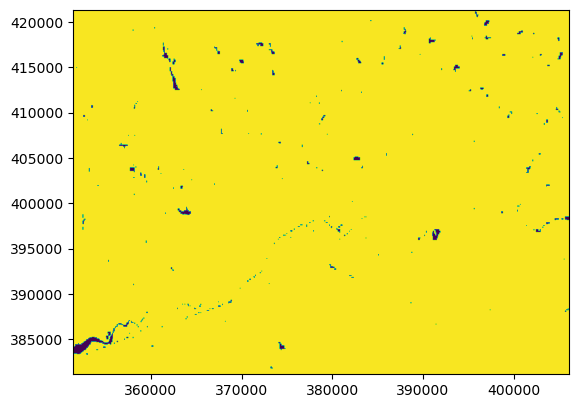

<AxesSubplot: >

In [12]:
# Plot the population TIFF image to check
fp = path+f'{iso_code}_{city}_2020_proj.tif'
img = rasterio.open(fp)
show(img)

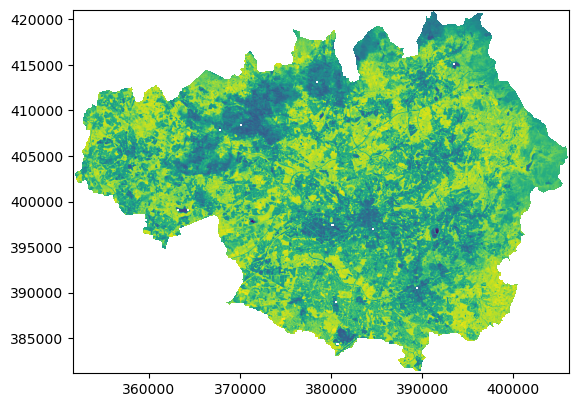

<AxesSubplot: >

In [47]:
# Plot the NDVI TIFF image to check
fp = path+f'{city}_2020_NDVI.tif'
img = rasterio.open(fp)
show(img)

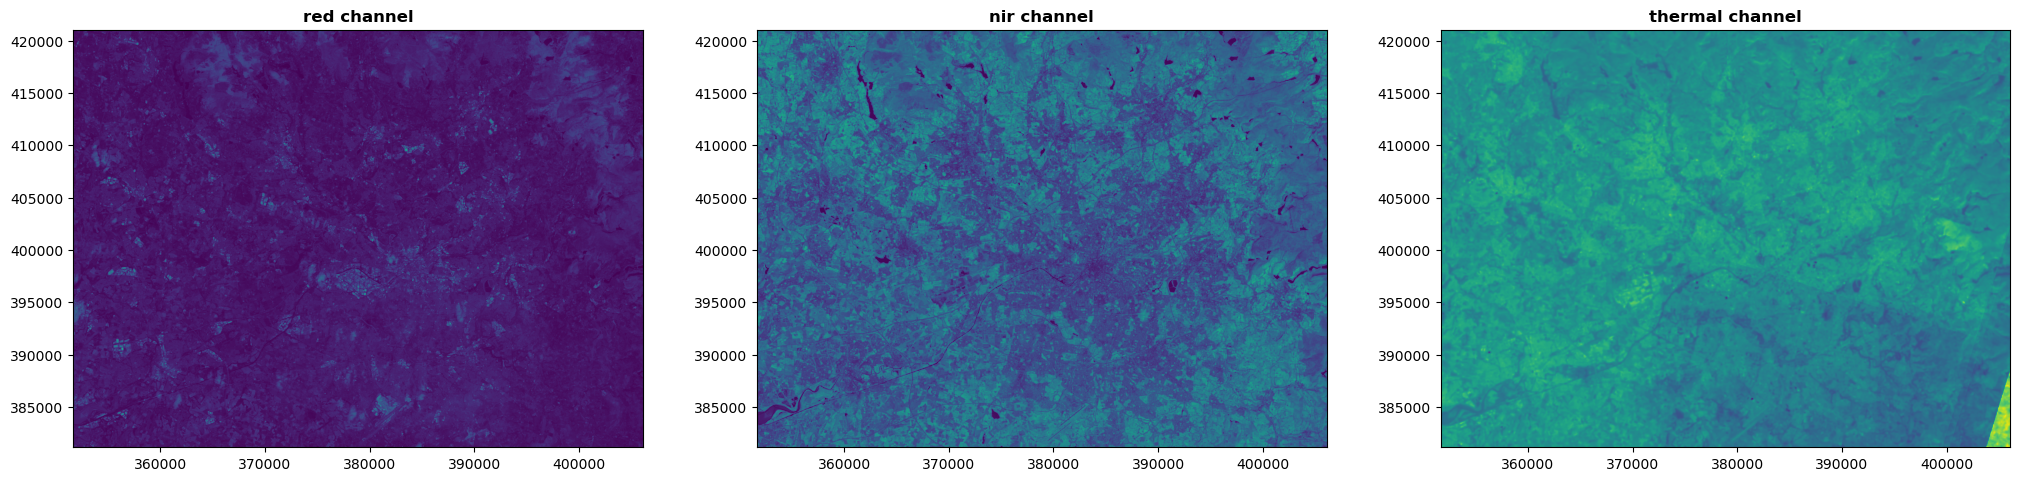

In [48]:
#Plotting LST sub channel files
# Checking files
fp = path+f'{city}_2020_red.tif'
fp2 = path+f'{city}_2020_nir.tif'
fp3 = path+f'{city}_2020_thermal.tif'
img = rasterio.open(fp)
img2 = rasterio.open(fp2)
img3 = rasterio.open(fp3)

# Plot
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(25,8))
show((img), ax=axr, title='red channel')
show((img2), ax=axg, title='nir channel')
show((img3), ax=axb, title='thermal channel')
plt.show()

In [54]:
# Calculate LST layer

# Load in each band that was exported from GEE
red = rasterio.open(path+f'{city}_2020_red.tif')
nir = rasterio.open(path+f'{city}_2020_nir.tif')
thermal = rasterio.open(path+f'{city}_2020_thermal.tif')

# Read the bands to be used for calculation
redImage = red.read(1).astype('f4')
nirImage = nir.read(1).astype('f4')
thermalImage = thermal.read(1).astype('f4')

lst_image_single_window = single_window(thermalImage, redImage, nirImage, unit='celcius')
lst_image_single_window = lst_image_single_window - 273.15

# Define affine transformation
affine = red.transform
crs_red = citycrs

# Create new raster file with calculated variables
with rasterio.open(
    path+f'{city}_2020_LST.tif',
    mode="w",
    driver="GTiff",
    height=lst_image_single_window.shape[0],
    width=lst_image_single_window.shape[1],
    count=1,
    dtype=lst_image_single_window.dtype,
    crs=crs_red,
    transform=affine,
                    ) as new_dataset:
        new_dataset.write(lst_image_single_window, 1)

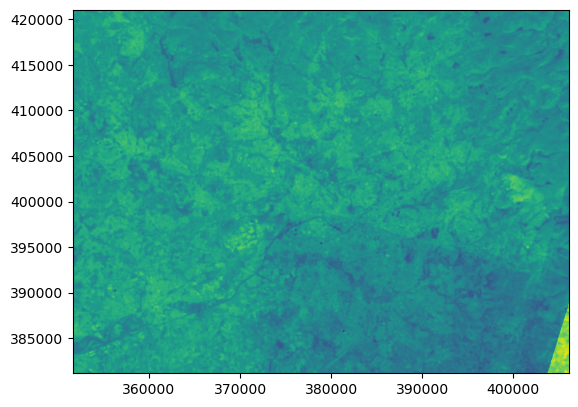

<AxesSubplot: >

In [59]:
# Checking LST file
fp = path+f'{city}_2020_LST.tif'
img = rasterio.open(fp)
show(img)

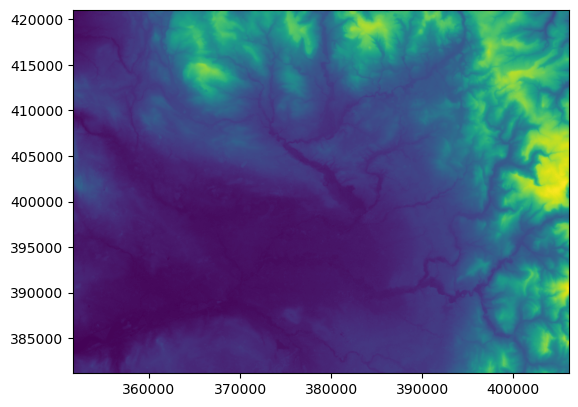

<AxesSubplot: >

In [60]:
# Checking DEM file
fp = path+f'{city}_DEM.tif'
img = rasterio.open(fp)
show(img)

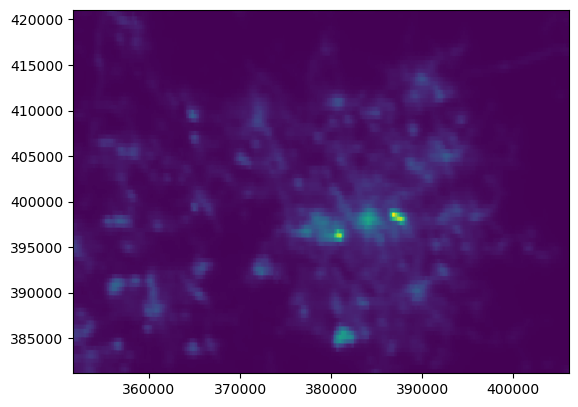

<AxesSubplot: >

In [63]:
# Checking NightLight file
fp = path+f'{city}_2022_NL.tif'
img = rasterio.open(fp)
show(img)

## Function that creates a grid of square polygons of 100 square meter containing the GEE population data
The function opens the population TIFF file from the specified path, creates a dataframe with pixels as rows, creates polygons and a geodataframe from the pixels, intersects the grid with the city's area, dissolves grid into larger grid cells containing the population and calculates their coordinates.

In [21]:
# Function to create population grids of the cities

def city_grids_format(city_grids, grid_size = 100):
    start_time = time.time()
    grids = []
    print(str(grid_size) + 'm resolution grids extraction')
        
    # Open the raster file
    with rasterio.open(city_grids) as src:
        band= src.read() # the population values
        aff = src.transform # the raster bounds and size (affine)

    # Get the rowwise arrays, get a 2D dataframe
    grid = pd.DataFrame()
    for b in enumerate(band[0]):
        grid = pd.concat([grid, pd.Series(b[1],name=b[0])],axis=1)
    grid= grid.unstack().reset_index()

    # Unstack df to columns
    grid.columns = ['row','col','value']
    grid['minx'] = aff[2]+aff[0]*grid['col']
    grid['miny'] = aff[5]+aff[4]*grid['row']
    grid['maxx'] = aff[2]+aff[0]*grid['col']+aff[0]
    grid['maxy'] = aff[5]+aff[4]*grid['row']+aff[4]

    # Create polygon from affine bounds and row/col indices
    grid['geometry'] = [Polygon([(grid.minx[i],grid.miny[i]),
                               (grid.maxx[i],grid.miny[i]),
                               (grid.maxx[i],grid.maxy[i]),
                               (grid.minx[i],grid.maxy[i])])\
                      for i in range(len(grid))]

    # Set the df as geo-df
    grid = gpd.GeoDataFrame(grid, crs = citycrsint) 

    # Get dissolvement_key for dissolvement. 
    grid['row3'] = np.floor(grid['row']/(grid_size/100)).astype(int)
    grid['col3'] = np.floor(grid['col']/(grid_size/100)).astype(int)
    grid['dissolve_key'] = grid['row3'].astype(str) +'-'+ grid['col3'].astype(str)

    # Define a city's OSM area as Polygon.
    # Get city area
    OSM_area = cities_adj[cities_adj['City'] == city]['OSM_area'][0].rsplit(', ')
    # Get the city geom
    geo_ls = gpd.GeoSeries(city_geo(OSM_area).dissolve().geometry)
    geo_ls = geo_ls.to_crs(citycrs)

    # Intersect grids with the city boundary Polygon.
    insec = grid.intersection(geo_ls.tolist()[0])

    # Exclude grids outside the specified city boundaries
    insec = insec[insec.area > 0]

    # Join in other information.
    insec = gpd.GeoDataFrame(geometry = insec, 
                             crs = citycrsint).join(grid.loc[:, grid.columns != 'geometry'])

    # Dissolve into block by block grids
    popgrid = insec[['dissolve_key','geometry','row3','col3']].dissolve('dissolve_key')

    # Get those grids populations
    popgrid['population'] = round(insec.groupby('dissolve_key')['value'].sum()).astype(int)
    popgrid = popgrid[popgrid['population'] >= 0]

    # Get centroids and coords
    popgrid['centroid'] = popgrid['geometry'].centroid
    popgrid['grid_lon'] = popgrid['centroid'].x
    popgrid['grid_lat'] = popgrid['centroid'].y
    popgrid = popgrid.reset_index()

    minx = popgrid.bounds['minx']
    maxx = popgrid.bounds['maxx']
    miny = popgrid.bounds['miny']
    maxy = popgrid.bounds['maxy']

    # Some geometries result in a multipolygon when dissolving (like i.e. 0.05 meters), coords error.
    # Therefore recreate the polygon.
    Poly = []
    for k in range(len(popgrid)):
        Poly.append(Polygon([(minx[k],maxy[k]),(maxx[k],maxy[k]),(maxx[k],miny[k]),(minx[k],miny[k])]))
    popgrid['geometry'] = Poly

    grids.append(popgrid)

    print(city_grids.rsplit('_')[4], round((time.time() - start_time)/60,2),'mns')
    return(grids)

## Creation of the population grid
Execute the 'city_grids_format' function by specifying the extracted population TIFF file path and the size of the grid cells (100 meter, 200 meter, 300 meter etc.)  Still takes a while! 12.5 mins on a MacBook Pro from 2015.

In [23]:
# Creation of the population grid

# format population grids
population_grids = city_grids_format(path+f'{iso_code}_{city}_2020_proj.tif',
                                     grid_size = 100) # aggregating upwards to i.e. 200m, 300m etc. is possible
print(' ')

# Get the dataframe
popgrid = population_grids[0]

100m resolution grids extraction
Manchester 12.21 mns
 


In [ ]:
# Adding grid_lat/lon degrees using crs 4326 for OSMNX distance calculations
popgrid = popgrid.to_crs("EPSG:4326")
popgrid['grid_lon_4326'] = popgrid.geometry.centroid.x
popgrid['grid_lat_4326'] = popgrid.geometry.centroid.y
# back to projected crs in meters
popgrid = popgrid.to_crs(citycrs)

## Creating grid bufferzones
- A separate geodataframe with bufferzones for each grid cell is created and intersected with the area of the city of interest to compensate for bufferzones extending out of the area.
- The buffers are used to create the upcoming environment variables.
- This operation is performed using parallelization with the 'joblib' package. This efficiently runs operations in parallel across different available cpu cores, speeding up operations significantly.

In [22]:
# Create bufferzone dataframe from population grid dataframe geometries
buffer_gdf = popgrid.copy()
buffer_gdf['geometry'] = buffer_gdf['geometry'].centroid.buffer(500)
buffer_gdf = buffer_gdf[['geometry']]

In [ ]:
# Intersect with bounds of the OSM city area so buffers don't extent beyond city borders
manpoly = city_geo(cities_adj['OSM_area'][0]).dissolve()['geometry']
manpoly = manpoly.to_crs(citycrs)

# Intersection function to be called by the joblib delayed() function
def get_intersection(gdf, other):
    return gdf.intersection(other)

# Initialization with less cores and rows due to kernel crashing
num_processes = 2
bufferintersect = Parallel(n_jobs=num_processes, prefer="threads")(delayed(get_intersection)(i, manpoly.geometry[0]) 
                                                 for i in buffer_gdf.geometry[0:1])

# All threads
num_processes = -1 # -1 means using all processors
start_time = time.time()
bufferintersect = Parallel(n_jobs=num_processes, prefer="threads")(delayed(get_intersection)(i, manpoly.geometry[0]) 
                                                 for i in buffer_gdf.geometry)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [38]:
# Convert to gdf
bufferintersect_gdf = gpd.GeoDataFrame(geometry=bufferintersect)
bufferintersect_gdf = bufferintersect_gdf.set_crs(citycrs)

## Creating the population and remote sensing variables
- The creation is done by means of the intersection of the values from the TIFF files with each of the buffers. This is done with the get_zonal_stats() functions from the 'rasterstats' package.
- This is also done via parallel processing using 'joblib'.

### Total population per grid bufferzone

In [ ]:
# Use the population TIFF
with rasterio.open(path+f'{iso_code}_{city}_2020_proj.tif') as src:
    affine = src.transform
    array = src.read(1)
    
# Get population sum statistic per bufferzone
def get_zonal_stats(gdf):
    return zonal_stats(gdf, array, affine=affine, stats=['sum'], nodata=0)

# Initialization with less cores and rows due to kernel crashing
num_processes = 2
statistics = Parallel(n_jobs=num_processes)(delayed(get_zonal_stats)(i) 
                                            for i in bufferintersect_gdf.geometry[0:1])

# All threads
num_processes = -1 # -1 means using all processors
start_time = time.time()
statistics = Parallel(n_jobs=num_processes)(delayed(get_zonal_stats)(i) 
                                            for i in bufferintersect_gdf.geometry)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [49]:
# Extract the population sum per buffer from statistics
# Setting values to zero if negative or None 
population_sums = [stat['sum'] if (stat and 'sum' in stat and stat['sum'] >= 0) 
                   else 0 for sublist in statistics for stat in sublist]

# Converting to df to add to the population grid gdf
population_sums_df = pd.DataFrame(population_sums, columns={'buffer_population': population_sums})

# Adding index to merge
population_sums_df['index'] = population_sums_df.index

# Adding as column to popgrid
popgrid = popgrid.merge(population_sums_df, on='index')

### Average NDVI per grid bufferzone

In [ ]:
# Use the NDVI TIFF
with rasterio.open(path+f'{city}_2020_NDVI.tif') as src:
    affine = src.transform
    array = src.read(1)
    
# Get NDVI mean statistic per bufferzone
def get_zonal_stats(gdf):
    return zonal_stats(gdf, array, affine=affine, stats=['mean'], nodata=0)

# Initialization with less cores and rows due to kernel crashing
num_processes = 2
statistics_ndvi = Parallel(n_jobs=num_processes)(delayed(get_zonal_stats)(i) 
                                            for i in bufferintersect_gdf.geometry[0:1])

# All threads
num_processes = -1 # -1 means using all processors
start_time = time.time()
statistics_ndvi = Parallel(n_jobs=num_processes)(delayed(get_zonal_stats)(i) 
                                            for i in bufferintersect_gdf.geometry)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [72]:
# Extract the NDVI mean per buffer from statistics
# Setting values to zero if negative or None
ndvi_means = [stat['mean'] if (stat and 'mean' in stat and stat['mean'] >= 0) 
              else 0 for sublist in statistics_ndvi for stat in sublist]

# Converting to df to add to the population grid gdf
ndvi_means_df = pd.DataFrame(ndvi_means, columns={'buffer_NDVI_mean': ndvi_means})

# Adding index to merge
ndvi_means_df['index'] = ndvi_means_df.index

# Adding as column to popgrid
popgrid = popgrid.merge(ndvi_means_df, on='index')

### Average LST per grid bufferzone

In [ ]:
# Use the LST TIFF
with rasterio.open(path+f'{city}_2020_LST.tif') as src:
    affine = src.transform
    array = src.read(1)
    
# Get LST mean statistic per bufferzone
def get_zonal_stats(gdf):
    return zonal_stats(gdf, array, affine=affine, stats=['mean'], nodata=0)

# Initialization with less cores and rows due to kernel crashing
num_processes = 2
statistics_lst = Parallel(n_jobs=num_processes)(delayed(get_zonal_stats)(i) 
                                            for i in bufferintersect_gdf.geometry[0:1])

# All threads
num_processes = -1 # -1 means using all processors
start_time = time.time()
statistics_lst = Parallel(n_jobs=num_processes)(delayed(get_zonal_stats)(i) 
                                            for i in bufferintersect_gdf.geometry)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [95]:
# Extract the LST mean per buffer from statistics
# Setting values to zero if negative or None
lst_means = [stat['mean'] if (stat and 'mean' in stat and stat['mean'] >= 0) 
             else 0 for sublist in statistics_lst for stat in sublist]

# Converting to df to add to the population grid gdf
lst_means_df = pd.DataFrame(lst_means, columns={'buffer_LST_mean': lst_means})

# Adding index to merge
lst_means_df['index'] = lst_means_df.index

# Add as column to popgrid
popgrid = popgrid.merge(lst_means_df, on='index')

### Average DEM per grid bufferzone

In [ ]:
# Use the DEM TIFF
with rasterio.open(path+f'{city}_DEM.tif') as src:
    affine = src.transform
    array = src.read(1)
    
# Get DEM mean statistic per bufferzone
def get_zonal_stats(gdf):
    return zonal_stats(gdf, array, affine=affine, stats=['mean'], nodata=0)

# Initialization with less cores and rows due to kernel crashing
num_processes = 2
statistics_dem = Parallel(n_jobs=num_processes)(delayed(get_zonal_stats)(i) 
                                            for i in bufferintersect_gdf.geometry[0:1])

# All threads
num_processes = -1 # -1 means using all processors
start_time = time.time()
statistics_dem = Parallel(n_jobs=num_processes)(delayed(get_zonal_stats)(i) 
                                            for i in bufferintersect_gdf.geometry)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [115]:
# Extract the DEM mean per buffer from statistics
# Setting values to zero if negative or None
dem_means = [stat['mean'] if (stat and 'mean' in stat and stat['mean'] >= 0) 
             else 0 for sublist in statistics_dem for stat in sublist]

# Converting to df to add to the population grid gdf
dem_means_df = pd.DataFrame(dem_means, columns={'buffer_DEM_mean': dem_means})

# Adding index to merge
dem_means_df['index'] = dem_means_df.index

# Add as column to popgrid
popgrid = popgrid.merge(dem_means_df, on='index')

### Average Night Light per grid bufferzone

In [ ]:
# Use the Night Light TIFF
with rasterio.open(path+f'{city}_2022_NL.tif') as src:
    affine = src.transform
    array = src.read(1)
    
# Get Night Light mean statistic per bufferzone
def get_zonal_stats(gdf):
    return zonal_stats(gdf, array, affine=affine, stats=['mean'], nodata=0)

# Initialization with less cores and rows due to kernel crashing
num_processes = 2
statistics_nl = Parallel(n_jobs=num_processes)(delayed(get_zonal_stats)(i) 
                                            for i in bufferintersect_gdf.geometry[0:1])

# All threads
num_processes = -1 # -1 means using all processors
start_time = time.time()
statistics_nl = Parallel(n_jobs=num_processes)(delayed(get_zonal_stats)(i) 
                                            for i in bufferintersect_gdf.geometry)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [275]:
# Extract the Night Light mean per buffer from statistics
# Setting values to zero if negative or None
nl_means = [stat['mean'] if (stat and 'mean' in stat and stat['mean'] >= 0) 
            else 0 for sublist in statistics_nl for stat in sublist]

# Converting to df to add to the population grid gdf
nl_means_df = pd.DataFrame(nl_means, columns={'buffer_NightLight_mean': nl_means})

# Adding index to merge
nl_means_df['index'] = nl_means_df.index

# Add as column to popgrid
popgrid = popgrid.merge(nl_means_df, on='index')

### Population density per grid bufferzone

In [57]:
# Adding population per buffer to buffer_gdf and then calculating density
bufferintersect_gdf['buffer_area'] = bufferintersect_gdf['geometry'].area

# Adding both buffer population and buffer area columns to final gdf for other density calculations
#popgrid['buffer_population'] = population_sums_df['buffer_population']
popgrid['buffer_area'] = bufferintersect_gdf['buffer_area']

# Calculating population density per buffer
popgrid['buffer_pop_density'] = popgrid['buffer_population']/popgrid['buffer_area']

# Converting population density to per km^2
popgrid['buffer_pop_density'] = popgrid['buffer_pop_density']*1000000

## Extracting street networks per grid bufferzone and retrieving street network areas
- The extraction of the street networks for each grid cell buffer is done by first extracting the entire street network of the city OSM area, then extract subgraphs for each grid cell buffer from that entire street network based on the street network nodes that intersect with each grid cell buffer. 
- A street network area is calculated by converting a subgraph to a geodataframe, transforming the geodataframe into one large polygon and getting its area. This is needed for density statistics.
- This is additionally done using parallelization.

In [ ]:
# Download whole street network of Greater Manchester from osmnx and project to CRS 27700
G = ox.graph_from_place(cities_adj['OSM_area'][0], network_type='all', simplify=True)
Gproj = ox.project_graph(G, to_crs=citycrsint)

In [103]:
# Get subgraphs for each grid instead of extracting the network per grid.
# Use the nodes from the whole street network of Greater Manchester, calculate their intersections 
# with buffer polygons and create the subgraph based on those intersected nodes.

# The function that returns the subgraph, it is called in the Parallel() function.
def get_subgraph(Gproj, Gproj_nodes, polygon):
    return Gproj.subgraph(Gproj_nodes[Gproj_nodes.intersects(polygon)].index)

# Get nodes from the Gproj 
Gproj_nodes = ox.graph_to_gdfs(Gproj, edges=False)

# Applying function via parallelization
# Initialize with less cores and rows due to kernel crashing
subgraph_list = Parallel(n_jobs=2, prefer="threads")(delayed(get_subgraph)(Gproj, Gproj_nodes, polygon) 
                                                     for polygon in bufferintersect_gdf.geometry[0:1])
# All cores
start_time = time.time()
subgraph_list = Parallel(n_jobs=-1, prefer="threads")(delayed(get_subgraph)(Gproj, Gproj_nodes, polygon) 
                                                      for polygon in bufferintersect_gdf.geometry)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 0.49338221549987793 seconds


In [ ]:
# Getting the subgraph area by turning the subgraph into a gdf..
#.. and turning that into one polygon via .convex_hull and getting its area.

# Function that is called in the Parallel() function
def get_subgraph_area(subgraph):
    try:
        return ox.graph_to_gdfs(subgraph, nodes=True, edges=False).unary_union.convex_hull.area
    except ValueError:
        return 0

# Applying the function via parallelization
# Initialize with less cores and rows due to kernel crashing
subgraph_area = Parallel(n_jobs=2, prefer="threads")(delayed(get_subgraph_area)(subgraph) 
                                                     for subgraph in subgraph_list[0:1])
# All cores
start_time = time.time()
subgraph_area = Parallel(n_jobs=-1, prefer="threads")(delayed(get_subgraph_area)(subgraph) 
                                                      for subgraph in subgraph_list)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

## Extraction of the street network statistics and removing missing values
- The street network statistics for the subgraphs are calculated using the basic_stats() function from 'osmnx'. The area is supplied to get street network density statistics. 
- The extraction of the street network stats takes a long time, even with parallelization! 23 hours on my decent desktop (i7 6700K overclocked, 32GB RAM 3200MHz).

In [ ]:
# Get the statistics from each subgraph and area and accounting for the..
#..errors that might occur due to a graph having no edges and giving a ValueError..
#..or due to the area being zero because the area is not able to be calculated..
#..from a graph with no edges!

# Function that is called in the Parallel() function
def get_stats(subgraph, area):
    try:
        return ox.stats.basic_stats(subgraph, area)
    except (ValueError, ZeroDivisionError):
        return 0

# Applying the function via parallelization, still took 23 hours..
# Initialize with less cores and rows due to kernel crashing
subgraph_stats = Parallel(n_jobs=2, prefer="threads")(delayed(get_stats)(subgraph, area) for subgraph, area 
                                    in islice(zip(subgraph_list, subgraph_area), 0, 1))
# All cores
start_time = time.time()
subgraph_stats = Parallel(n_jobs=-1, prefer="threads")(delayed(get_stats)(subgraph, area) for subgraph, area 
                                     in zip(subgraph_list, subgraph_area))
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [93]:
# Saving stats per subgraph in dataframe
# Also rename and convert the dict of statistics in each row to..
#..dataframe columns with json_normalize()
subgraphstats= pd.DataFrame(np.array(subgraph_stats))
subgraphstats = subgraphstats.rename(columns={0: "stats"})
subgraphstats = pd.json_normalize(subgraphstats['stats'])

In [96]:
# Remove columns that have lots of missing values
np.isnan(subgraphstats).sum() # check nans per columns

n                                  15165
m                                  15165
k_avg                              15165
edge_length_total                  15165
edge_length_avg                    15165
streets_per_node_avg               15165
intersection_count                 15165
street_length_total                15165
street_segment_count               15165
street_length_avg                  15165
circuity_avg                       15165
self_loop_proportion               15165
node_density_km                    15165
intersection_density_km            15165
edge_density_km                    15165
street_density_km                  15165
streets_per_node_counts.0          15165
streets_per_node_counts.1          15165
streets_per_node_counts.2          15165
streets_per_node_counts.3          15165
streets_per_node_counts.4          51135
streets_per_node_proportions.0     15165
streets_per_node_proportions.1     15165
streets_per_node_proportions.2     15165
streets_per_node

In [97]:
# Remove columns that have lots of missing values
subgraphstats = subgraphstats.drop(columns=['streets_per_node_counts.4',
                                            'streets_per_node_proportions.4', 
                                            'streets_per_node_counts.5', 
                                            'streets_per_node_proportions.5',
                                            'streets_per_node_counts.6',
                                            'streets_per_node_proportions.6',
                                            'streets_per_node_counts.7',
                                            'streets_per_node_counts.8',
                                            'streets_per_node_proportions.7', 
                                            'streets_per_node_proportions.8'])

# Add index to merge on index
subgraphstats['index'] = subgraphstats.index

# Concatenate the rest with the population grid gdf
popgrid = popgrid.merge(subgraphstats, on='index')

## Saving the final and buffer geodataframe for distance/diversity extractions

In [301]:
# Save the file to gpkg
popgrid.to_file('popgrid.gpkg', driver="GPKG")
bufferintersect_gdf.to_file('bufferintersect_gdf.gpkg', driver="GPKG")